# Russia Ukaraine war Twitter Sentiment Analaysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import re
from nltk.corpus import stopwords
import string

data = pd.read_csv("filename.csv")
print(data.head())

                    id      conversation_id               created_at  \
0  1549576342861058048  1549040663592706049  2022-07-20 02:06:04 UTC   
1  1549576341518819328  1549576341518819328  2022-07-20 02:06:04 UTC   
2  1549576327484690432  1549576327484690432  2022-07-20 02:06:00 UTC   
3  1549576325203214338  1549563998416379912  2022-07-20 02:06:00 UTC   
4  1549576316227387393  1549268210591027200  2022-07-20 02:05:58 UTC   

         date      time  timezone              user_id         username  \
0  2022-07-20  02:06:04         0             96581518        _jparker_   
1  2022-07-20  02:06:04         0            499107662   sputnik_brasil   
2  2022-07-20  02:06:00         0  1346353472183013376         mnownews   
3  2022-07-20  02:06:00         0  1514661511767150605  jonatan12356762   
4  2022-07-20  02:05:58         0            319880522     parabolicape   

               name place  ... geo source user_rt_id user_rt retweet_id  \
0         J. Parker   NaN  ... NaN    NaN

In [2]:
data.head(5)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1549576342861058048,1549040663592706049,2022-07-20 02:06:04 UTC,2022-07-20,02:06:04,0,96581518,_jparker_,J. Parker,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Mippymipper', 'name': '.', '...",NaN,NaN,NaN,NaN
1,1549576341518819328,1549576341518819328,2022-07-20 02:06:04 UTC,2022-07-20,02:06:04,0,499107662,sputnik_brasil,Sputnik Brasil,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1549576327484690432,1549576327484690432,2022-07-20 02:06:00 UTC,2022-07-20,02:06:00,0,1346353472183013376,mnownews,MalaysiaNow,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1549576325203214338,1549563998416379912,2022-07-20 02:06:00 UTC,2022-07-20,02:06:00,0,1514661511767150605,jonatan12356762,Jonatan,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'UOLNoticias', 'name': 'UOL N...",NaN,NaN,NaN,NaN
4,1549576316227387393,1549268210591027200,2022-07-20 02:05:58 UTC,2022-07-20,02:05:58,0,319880522,parabolicape,Daniel R 🇺🇸 🤝 🇺🇦,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'vox_unpopular', 'name': 'JK'...",NaN,NaN,NaN,NaN


Let’s have a quick look at all the column names of the dataset:

In [3]:
data.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

We only need three columns for this task (username, tweet, and language); I will only select these columns and move forward:

In [4]:
data = data[["username", "tweet", "language"]]

In [5]:
data.head()

,username,tweet,language
0,_jparker_,@Mippymipper @owen_v14 @IamTheSherm @comradeau...,en
1,sputnik_brasil,Restrições sobre o #petróleo da Rússia causarã...,pt
2,mnownews,"Russia deepens Iran ties against West, hits Uk...",en
3,jonatan12356762,@UOLNoticias O negócio tá feio prós petistas. ...,pt
4,parabolicape,@vox_unpopular I’m with you tho. It’s absolut...,en


Let’s have a look at whether any of these columns contains any null values or not:

In [6]:
data.isnull().sum()

username    0
tweet       0
language    0
dtype: int64

So none of the columns has null values, let’s have a quick look at how many tweets are posted in which language:

In [7]:
data["language"].value_counts()

en     8528
pt      789
it      126
qme      85
und      81
in       78
es       40
ru       34
ja       25
qam      23
ca       19
pl       18
fr       17
fi       15
nl       13
ar       13
zh       12
de       11
ro       10
vi        9
tl        9
qht       8
hi        7
et        5
uk        4
th        4
tr        4
ko        4
cy        3
no        3
iw        2
ur        2
cs        2
fa        2
ht        1
lt        1
am        1
mr        1
hu        1
da        1
Name: language, dtype: int64

So most of the tweets are in English. Let’s prepare this data for the task of sentiment analysis. Here I will remove all the links, punctuation, symbols and other language errors from the tweets:

In [8]:
#nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
data["tweet"] = data["tweet"].apply(clean)

Now let’s have a look at the wordcloud of the tweets, which will show the most frequently used words in the tweets by people sharing their feelings and updates about the Ukraine and Russia war:

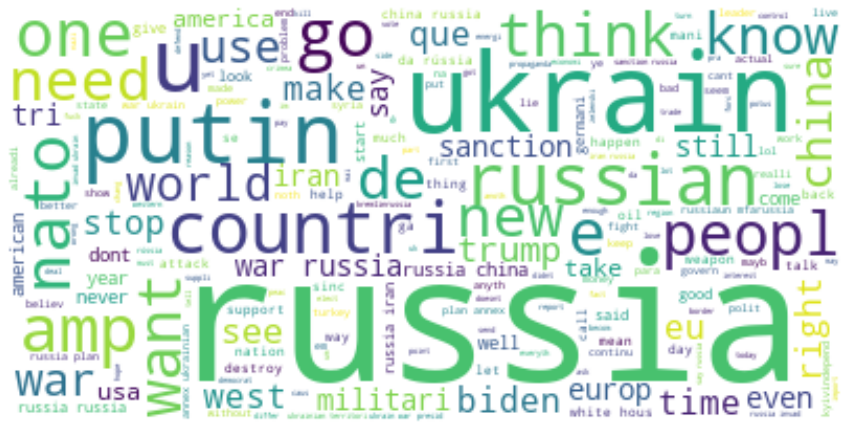

In [9]:
text = " ".join(i for i in data.tweet)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now I will add three more columns in this dataset as Positive, Negative, and Neutral by calculating the sentiment scores of the tweets:

In [10]:
#nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["tweet"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["tweet"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["tweet"]]
data = data[["tweet", "Positive", "Negative", "Neutral"]]
print(data.head())

                                               tweet  Positive  Negative  \
0  mippymipp  iamthesherm comradeaux that true it...     0.376     0.091   
1  restriçõ sobr petróleo da rússia causarão disp...     0.000     0.000   
2  russia deepen iran tie west hit ukrain missil ...     0.000     0.000   
3  uolnoticia negócio tá feio prós petista não qu...     0.000     0.000   
4  voxunpopular i'm tho  it absolut best interest...     0.455     0.172   

   Neutral  
0    0.533  
1    1.000  
2    1.000  
3    1.000  
4    0.373  


Now let’s have a look at the most frequent words used by people with positive sentiments:

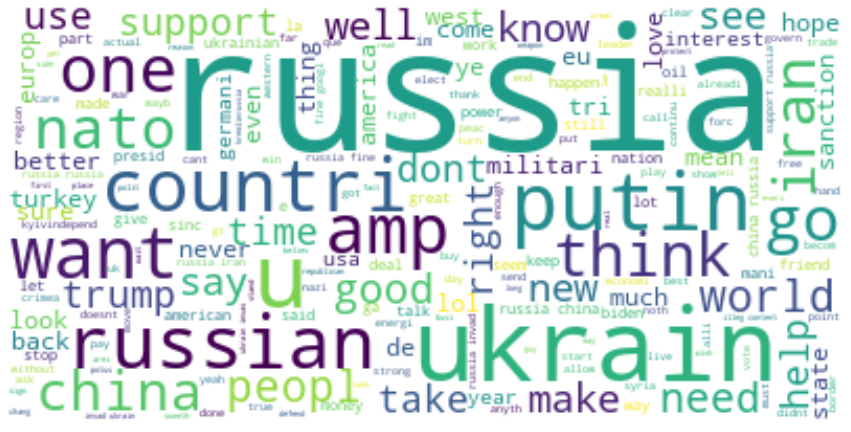

In [11]:
positive =' '.join([i for i in data['tweet'][data['Positive'] > data["Negative"]]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now let’s have a look at the most frequent words used by people with negative sentiments:

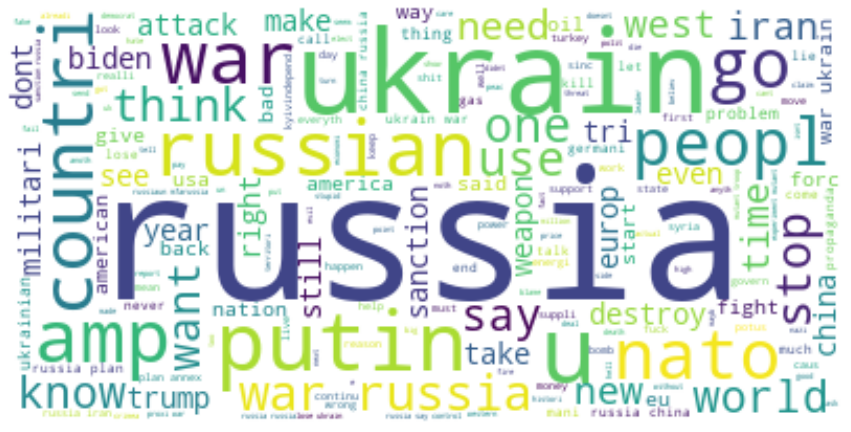

In [12]:
negative =' '.join([i for i in data['tweet'][data['Negative'] > data["Positive"]]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(negative)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

So this is how you can analyze the sentiments of people over the Ukraine and Russia war. I hope this war gets over soon and things get back to normal.